In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

In [15]:
# Загрузка данных и сэмплирование
df = pd.read_csv('../data/trips.csv', encoding="utf_16_le")
df = df.sample(frac=0.2, random_state=42)
print(df.shape)

(28975, 10)


In [16]:
# Преобразование временных меток
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Продолжительность поездки в минутах
df['duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

print(df.shape)

(28975, 11)


In [17]:
# Фильтр аномалий (поездки с отрицательной длительностью)
df = df[df['duration'] > 0]

# Извлекаем час и день недели
df['hour'] = df['started_at'].dt.hour
df['day_of_week'] = df['started_at'].dt.dayofweek.map({
    0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'
})

# Удаляем ненужные параметры
df.drop(["started_at", "ended_at", "start_station_name", "end_station_name", "start_lat", "start_lng", "end_lat", "end_lng"], axis=1, inplace=True)
# df.drop(["started_at", "ended_at"], axis=1, inplace=True)

print(df.shape)

# Кодирование категориальных признаков
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

# Целевая переменная
y = df['member_casual']

# Признаки
X = df[['duration', 'rideable_type', 'hour', 'day_of_week']]

df.head()

(28951, 5)


,rideable_type,member_casual,duration,hour,day_of_week
99113,1,0,10.933333,7,6
45484,1,0,3.283333,15,1
48706,0,0,3.883333,13,0
72234,1,1,5.233333,17,5
137251,0,1,10.133333,17,6


In [20]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scoring = ['accuracy', 'f1', 'roc_auc']

Random Forest CV Accuracy: 0.7683937823834197
Random Forest CV F1: 0.8642764791832344
Random Forest CV ROC AUC: 0.5798130997526023


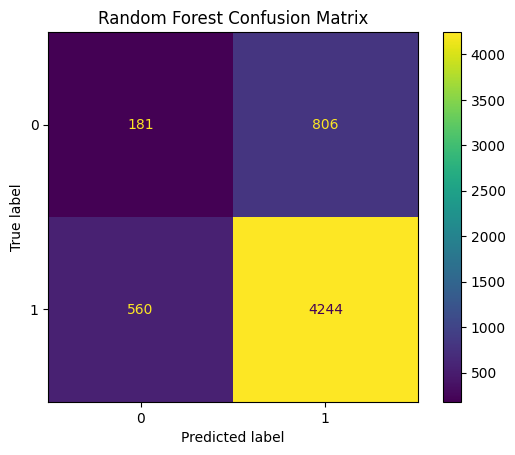

In [23]:
# Модель 1: Random Forest
rf = RandomForestClassifier(random_state=42)

cv_results_rf = cross_validate(rf, X_train, y_train, cv=5, scoring=scoring)

print("Random Forest CV Accuracy:", cv_results_rf['test_accuracy'].mean())
print("Random Forest CV F1:", cv_results_rf['test_f1'].mean())
print("Random Forest CV ROC AUC:", cv_results_rf['test_roc_auc'].mean())

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

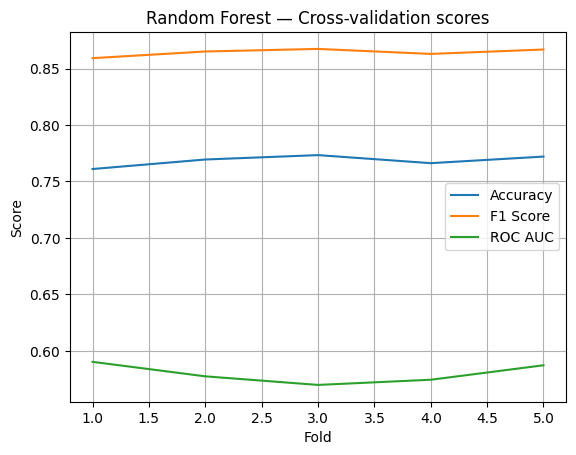

In [24]:
# Визуализация точности по фолдам
plt.plot(range(1, 6), cv_results_rf['test_accuracy'], label='Accuracy')
plt.plot(range(1, 6), cv_results_rf['test_f1'], label='F1 Score')
plt.plot(range(1, 6), cv_results_rf['test_roc_auc'], label='ROC AUC')
plt.title('Random Forest — Cross-validation scores')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

XGBoost CV Accuracy: 0.8224525043177892
XGBoost CV F1: 0.9017864085776315
XGBoost CV ROC AUC: 0.5982003356761765


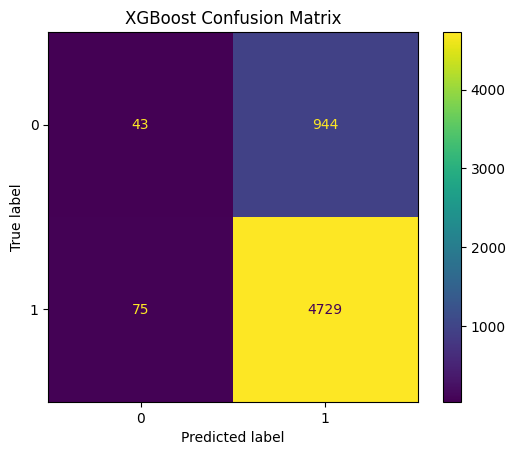

In [28]:
# Модель 2: XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

cv_results_xgb = cross_validate(xgb, X_train, y_train, cv=5, scoring=scoring)

print("XGBoost CV Accuracy:", cv_results_xgb['test_accuracy'].mean())
print("XGBoost CV F1:", cv_results_xgb['test_f1'].mean())
print("XGBoost CV ROC AUC:", cv_results_xgb['test_roc_auc'].mean())

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb)).plot()
plt.title("XGBoost Confusion Matrix")
plt.show()

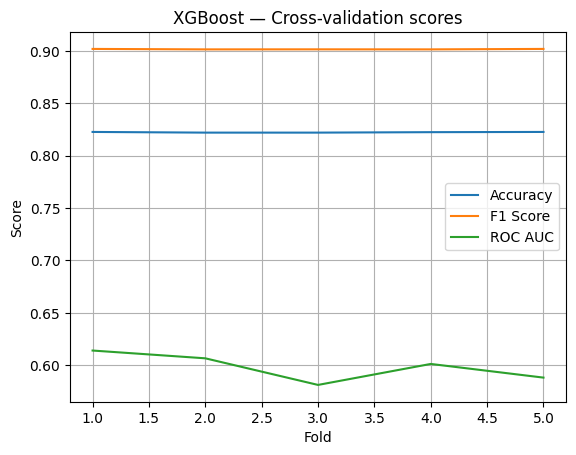

In [29]:
# Визуализация точности по фолдам
plt.plot(range(1, 6), cv_results_xgb['test_accuracy'], label='Accuracy')
plt.plot(range(1, 6), cv_results_xgb['test_f1'], label='F1 Score')
plt.plot(range(1, 6), cv_results_xgb['test_roc_auc'], label='ROC AUC')
plt.title('XGBoost — Cross-validation scores')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

Best params: {'max_depth': 7, 'min_samples_split': 2}
Best score: 0.8302677029360968


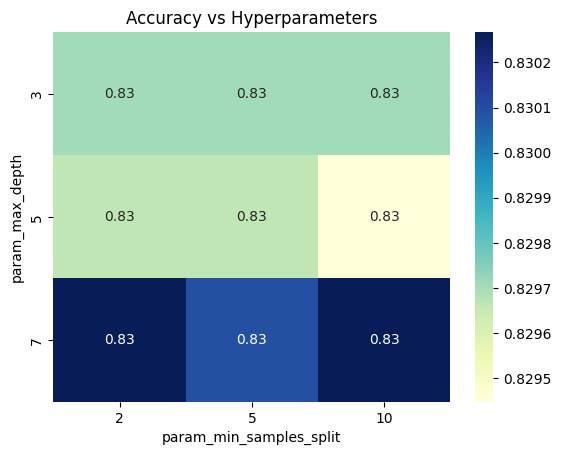

In [ ]:
# Подбор гиперпараметров для Random Forest
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

results = pd.DataFrame(grid_search.cv_results_)
pivot = results.pivot_table(index='param_max_depth', columns='param_min_samples_split', values='mean_test_score')
sns.heatmap(pivot, annot=True, cmap="YlGnBu")
plt.title("Accuracy vs Hyperparameters")
plt.show()

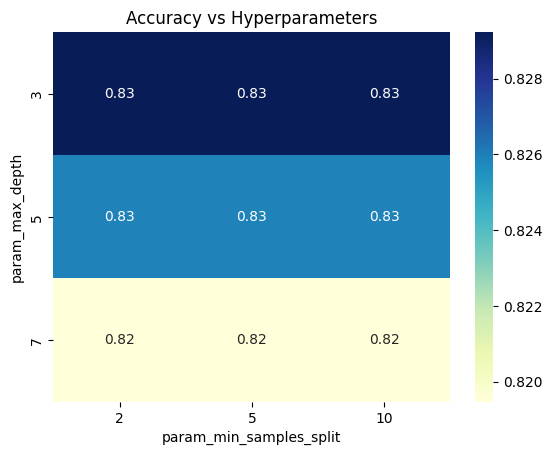

In [34]:
# Подбор гиперпараметров для XGBoost
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

grid_search_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
                              param_grid_xgb, scoring='accuracy', cv=5)
grid_search_xgb.fit(X_train, y_train)

results_xgb = pd.DataFrame(grid_search_xgb.cv_results_)
pivot_xgb = results_xgb.pivot_table(index='param_max_depth', columns='param_min_samples_split', values='mean_test_score')
sns.heatmap(pivot_xgb, annot=True, cmap="YlGnBu")
plt.title("Accuracy vs Hyperparameters")
plt.show()